# 1. Setting up environment
Need datasets for hugging face

In [1]:
!pip install datasets

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch

# redundant
from torch import optim
from torch.utils import data

import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2

from PIL import Image

import os
import copy
from copy import deepcopy

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2.1 Download Dataset

https://huggingface.co/datasets/microsoft/cats_vs_dogs

## 2.2 Cats dataset

In [4]:
from datasets import load_dataset
ds = load_dataset("microsoft/cats_vs_dogs")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
# Filter for only cats
cats_ds = ds.filter(lambda example: example['labels'] == 0)

In [6]:
# Split the dataset
train_test_split = cats_ds['train'].train_test_split(test_size=0.2, seed=42)
test_val_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)
train_dataset = train_test_split['train']['image']
val_dataset = test_val_split['train']['image']
test_dataset = test_val_split['test']['image']

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 9392
Validation dataset size: 1174
Test dataset size: 1175


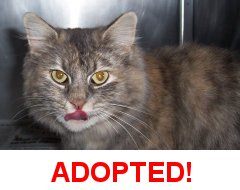

In [7]:
train_dataset[0]

In [8]:
hole_size = 5

def create_masks(N, im_h, im_w):
    x = int((im_w - hole_size) / 2.0)
    y = int((im_h - hole_size) / 2.0)
    mask = torch.zeros((1, im_h, im_w))
    mask[0, y : y + hole_size, x : x + hole_size] = 1
    masks = mask.repeat_interleave(N, dim=0)
    # masks = torch.cat(masks, dim=0)
    return masks.unsqueeze(1)

In [9]:
class CatDataset(Dataset):
    def __init__(self, all_imgs, transforms=None) -> None:
        super().__init__()
        self.transforms = transforms
        self.all_imgs = all_imgs


    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, index):
        image = self.all_imgs[index]

        transformed_img = self.transforms(image) if self.transforms else image
        # transformed_img = transformed_img[0]

        # Ensure transformed_img always has 3 channels
        # transformed_img = self.transforms(image) if self.transforms else image
        if transformed_img.shape[0] == 1:  # Check if image has only 1 channel
            transformed_img = transformed_img.repeat(3, 1, 1)  # Repeat to get 3 channels


        # create deep copy of image for transformation
        ground_truth_image = deepcopy(transformed_img)

        # # change center depending on where to randomize
        mask = create_masks(1,32,32)[0]
        # transformed_img = (1 - mask) * transformed_img
        # transformed_img[:, 10:20, 10:20] = torch.rand((3, 10, 10))
        #transformed_img[:, 96:160, 96:160] = torch.rand((3, 64, 64))

        return transformed_img, ground_truth_image

In [32]:
transforms = v2.Compose([
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    v2.Resize(size=(32, 32))
])

transformed_train_dataset = CatDataset(train_dataset, transforms=transforms)
transformed_val_dataset = CatDataset(val_dataset, transforms=transforms)
transformed_test_dataset = CatDataset(test_dataset, transforms=transforms)

## 2.4 Explore Dataset

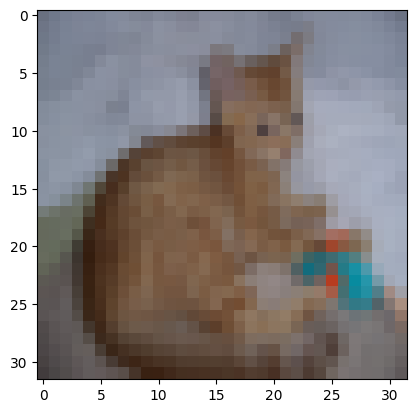

In [31]:
def imshow(tensor):
    if len(tensor.shape) == 4:
        tensor = tensor[0]
    plt.imshow(tensor.cpu()[:3].permute(1, 2, 0))

imshow(train[1000][0])

In [12]:
transformed_train_dataset[0][0].shape

torch.Size([3, 32, 32])

In [13]:
transformed_train_dataset[341][0].shape

torch.Size([3, 32, 32])

torch.Size([3, 32, 32])


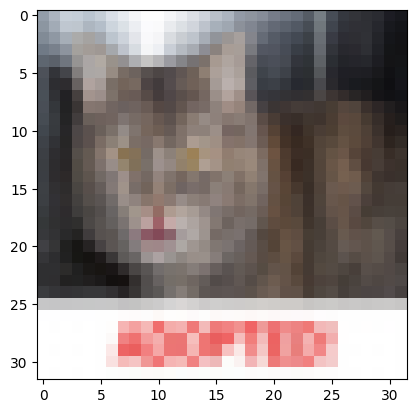

In [14]:
plt.imshow(np.transpose(transformed_train_dataset[0][0], (1, 2, 0)))
print(transformed_train_dataset[0][0].shape)

In [15]:
def create_hole_mask(im_h, im_w, hole_h, hole_w):
    i = int((im_h - hole_h + 1) * np.random.random())
    j = int((im_w - hole_w + 1) * np.random.random())
    mask = torch.zeros((1, im_h, im_w))
    mask[0, i : i + hole_h, j : j + hole_w] = 1
    return mask, (i, i + hole_h, j, j + hole_w)

def create_hole_masks(N, im_h, im_w, hole_h, hole_w, same_size=True):
    if same_size:
        masks = [create_hole_mask(im_h, im_w, hole_h, hole_w) for _ in range(N)]
    else:
        h_min, h_max = hole_h
        w_min, w_max = hole_w
        hs, ws = np.random.randint(h_min, h_max, N), np.random.randint(w_min, w_max, N)
        masks = [create_hole_mask(im_h, im_w, h, w) for h, w in zip(hs, ws)]

    bounds = [mask[1] for mask in masks]
    masks = [mask[0] for mask in masks]
    masks = torch.cat(masks, dim=0)
    return masks.unsqueeze(1), bounds



In [16]:
create_hole_masks(2, 3, 3, 1, 1)

(tensor([[[[0., 0., 0.],
           [0., 0., 0.],
           [0., 1., 0.]]],
 
 
         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 1., 0.]]]]),
 [(2, 3, 1, 2), (2, 3, 1, 2)])

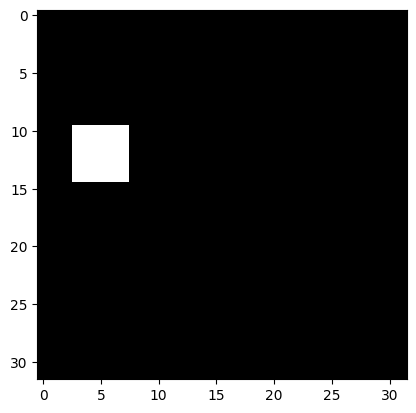

In [17]:
plt.imshow(create_hole_mask(32, 32, 5, 5)[0][0], cmap='gray')

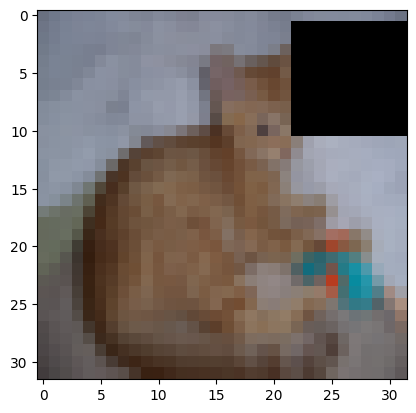

In [18]:
imshow((1 - create_hole_mask(32, 32, 10, 10)[0][0]) * transformed_train_dataset[1000][0])

In [19]:
item0, item1, item2 = transformed_train_dataset[10], transformed_train_dataset[1], transformed_train_dataset[2]

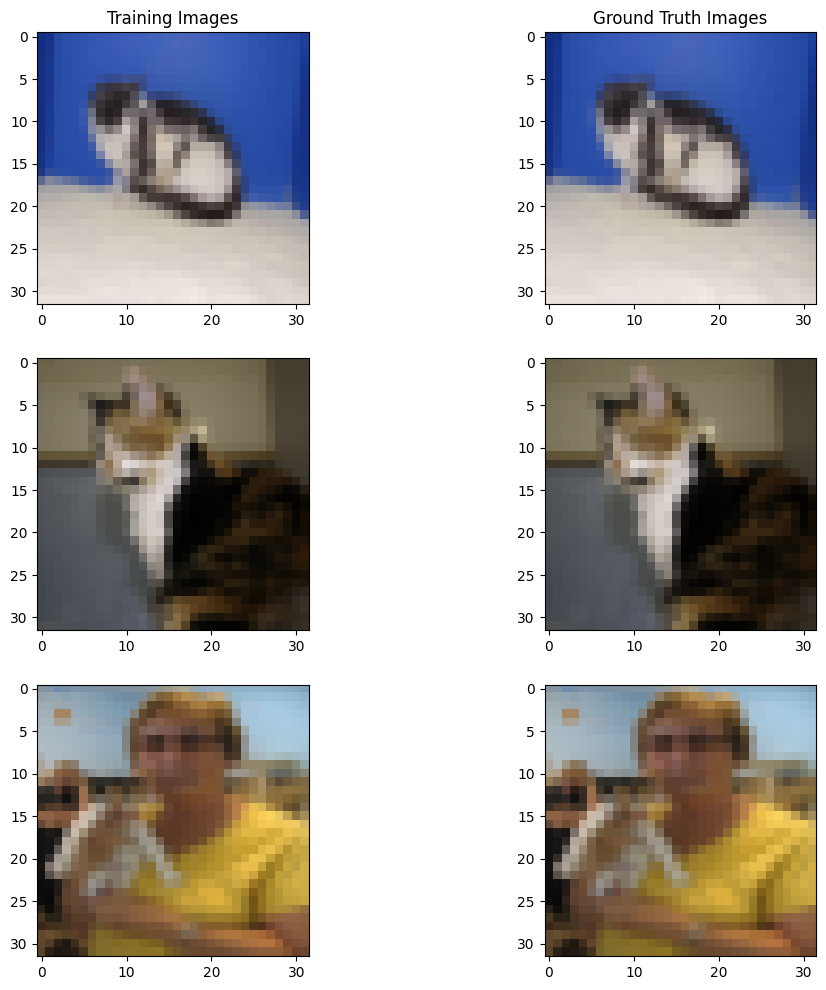

In [20]:
# train image
f, ax = plt.subplots(3, 2, figsize=(12, 12))
ax[0, 0].imshow(np.transpose(item0[0], (1, 2, 0)))
ax[0, 1].imshow(np.transpose(item0[1], (1, 2, 0)))
ax[1, 0].imshow(np.transpose(item1[0], (1, 2, 0)))
ax[1, 1].imshow(np.transpose(item1[1], (1, 2, 0)))
ax[2, 0].imshow(np.transpose(item2[0], (1, 2, 0)))
ax[2, 1].imshow(np.transpose(item2[1], (1, 2, 0)))

ax[0, 0].set_title("Training Images");
ax[0, 1].set_title("Ground Truth Images");


## 2.5 Setup Dataloader

In [21]:
BATCH_SIZE = 8
train_loader = DataLoader(transformed_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(transformed_val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(transformed_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Testing with Generator/Discriminator, to modify later

In [22]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

class Unflatten(nn.Module):

    def __init__(self, shape):
        super(Unflatten, self).__init__()
        self.shape = shape

    def forward(self, X):
        return X.view(-1, *self.shape)

class Generator(nn.Module):

    def __init__(self, im_channels):
        super(Generator, self).__init__()


        self.net = nn.Sequential(
            nn.Conv2d(im_channels + 1, 64, 5, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),


            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 256, 3, stride=1, padding=2, dilation=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=4, dilation=4),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=8, dilation=8),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=16, dilation=16),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),

            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, im_channels, 3, stride=1, padding=1)

        )

    def forward(self, X):
        out = self.net(X)
        return out

# g = Generator(2)
# g.eval()
# g(train[0][0].unsqueeze(0)).shape

In [23]:
class LocalDiscriminator(nn.Module):
    def __init__(self, im_channels, region_size=16):
        super(LocalDiscriminator, self).__init__()

        self.region_size = region_size

        self.net = nn.Sequential(
            nn.Conv2d(im_channels + 1, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
            Flatten(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(1024)
        )

    def forward(self, X, mask_bounds):

        local_regions = self._get_local_regions(X, mask_bounds)
        out = self.net(local_regions)

        return out

    def _get_local_regions(self, X, mask_bounds):

        N, ch, im_h, im_w = X.shape
        local_regions = torch.zeros((N, ch, self.region_size, self.region_size)).cuda()

        for i, bounds in enumerate(mask_bounds):
            y1, y2, x1, x2 = bounds

            ym, xm = (y1 + y2) // 2, (x1 + x2) // 2
            y1, x1 = ym - self.region_size // 2, xm - self.region_size // 2
            y2, x2 = y1 + self.region_size, x1 + self.region_size

            if y1 < 0:
                y1, y2 = 0, self.region_size
            elif y2 > im_h:
                y1, y2 = im_h - self.region_size, im_h

            if x1 < 0:
                x1, x2 = 0, self.region_size
            elif x2 > im_w:
                x1, x2 = im_w - self.region_size, im_w

            local_regions[i, :, :, :] = X[i, :, y1 : y2, x1 : x2]

        return local_regions

In [24]:
class GlobalDiscriminator(nn.Module):
    def __init__(self, im_channels):
        super(GlobalDiscriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(im_channels + 1, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
#             nn.Conv2d(512, 512, 5, stride=2, padding=2),
#             nn.LeakyReLU(0.1),
#             nn.BatchNorm2d(512),
            Flatten(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(1024)
        )

    def forward(self, X):
        out = self.net(X)
        return out



In [25]:
class Discriminator(nn.Module):
    def __init__(self, local_d, global_d):
        super(Discriminator, self).__init__()
        self.local_discriminator = local_d
        self.global_discriminator = global_d
        self.fc = nn.Linear(2048, 1)

    def forward(self, X, mask_bounds):
        local_ = self.local_discriminator(X, mask_bounds)
        global_ = self.global_discriminator(X)
        concated = torch.cat((local_, global_), dim=1)
        out = self.fc(concated)

        return out


# training, modify to fit our data loaders

In [26]:
import time

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

def train_gan(g, d, train, val, g_o, d_o, params, masks_fn):

    train_loader = DataLoader(train, batch_size=params['batch_size'], num_workers=0, pin_memory=True)
    val_loader = DataLoader(val, params['val_batch_size'], shuffle=True, pin_memory=True)
    val_loader = iter(cycle(val_loader))

    optimizer_g = g_o
    optimizer_d = d_o

    T_c, T_d = params['T_c'], params['T_d']
    w = params['w']
    for epoch in range(params['epochs']):
        ep_loss_g = 0.
        ep_loss_d = 0.
        fake_err = 0.
        real_err = 0.

        if epoch < T_c and epoch == 0:
                print(f'\n>>>> Training generator for {T_c} epochs.')

        if epoch < T_c + T_d and epoch == T_c:
                print(f'\n>>>> Training discriminator for {T_d} epochs.')

        if epoch == T_c + T_d:
                print(f'\n>>>> Training both generator and discriminator jointly.')

        start_time = time.time()

        g.train()
        d.train()
        for batch, _ in train_loader:

            N = batch.shape[0]
            batch = batch.cuda()

            masks_g, bounds_g = masks_fn(N)
            batch_masked = batch.clone() * (1 - masks_g)
            batch_with_masks = torch.cat((batch_masked, masks_g[:, :1]), dim=1)

            fake = g(batch_with_masks)

            loss_mse = (((batch - fake) * masks_g)**2).sum() / masks_g.sum()

            if epoch < T_c:
                loss_g = loss_mse
                loss_g.backward()
                optimizer_g.step()
                optimizer_g.zero_grad()
                ep_loss_g += loss_g.detach().cpu()
                continue
            else:
                inpainted = batch.clone()
                masks_byte = masks_g.byte()
                inpainted[masks_byte] = fake.detach()[masks_byte].view(-1)
                inpainted = torch.cat((inpainted, masks_g[:, :1]), dim=1)
                d_fake = d(inpainted.detach(), bounds_g)

                masks_d, bounds_d = masks_fn(N)
                real = torch.cat((batch.clone(), masks_d[:, :1]), dim=1)
                d_real = d(real, bounds_d)

                loss_d_fake = (d_fake**2).mean()
                loss_d_real = ((d_real - 1)**2).mean()
                loss_d = (loss_d_fake + loss_d_real) / 2
                loss_d.backward()
                optimizer_d.step()
                optimizer_d.zero_grad()

                if epoch >= T_c + T_d:
                    inpainted = batch.clone()
                    inpainted[masks_byte] = fake[masks_byte].view(-1)
                    inpainted = torch.cat((inpainted, masks_g[:, :1]), dim=1)
                    d_fake = d(inpainted, bounds_g)
                    loss_g = loss_mse + w * ((d_fake - 1)**2).mean()

                    loss_g.backward()
                    optimizer_g.step()
                    optimizer_g.zero_grad()

                    ep_loss_g += loss_g.detach().cpu()

                ep_loss_d += loss_d.detach().cpu()
                fake_err += loss_d_fake.detach().cpu()
                real_err += loss_d_real.detach().cpu()
#             break

        if not T_c <= epoch < T_c + T_d:
            g.eval()
            val_batch = next(val_loader)[0].cuda()
            N, ch, _, _ = val_batch.shape

            masks, _ = masks_fn(N)
            val_batch_masked = val_batch * (1 - masks)
            val_batch_masked = torch.cat((val_batch_masked, masks[:, :1]), dim=1)
            val_pred = g(val_batch_masked).detach()
            val_loss = (((val_batch - val_pred) * masks)**2).sum() / masks.sum()
            inpainted = val_batch.clone()
            masks_byte = masks.byte()
            inpainted[masks_byte] = val_pred[masks_byte]
            imgs = [
                val_batch[0].cpu(),
                masks[0].cpu(),
                val_batch_masked[:, :-1][0].cpu(),
                val_pred[0].cpu().clamp(0, 1),
                inpainted[0].cpu()
            ]
            imshow(torch.cat(imgs, dim=2))
            plt.axis('off')
            plt.show()

        print('epoch: %d, g_loss: %0.4f, val_loss: %0.4f, d_loss: %0.4f, fake_err: %0.4f, real_err: %0.4f, time: %0.2f' %\
              (epoch, ep_loss_g, val_loss, ep_loss_d, fake_err, real_err, time.time() - start_time))

In [27]:
global_d = GlobalDiscriminator(im_channels=3).cuda()
local_d = LocalDiscriminator(im_channels=3, region_size=16).cuda()
discriminator = Discriminator(local_d=local_d, global_d=global_d).cuda()

generator = Generator(im_channels=3).cuda()


In [28]:
transformed_test_dataset


>>>> Training both generator and discriminator jointly.


<ipython-input-26-a7d8eb7fd97a>:61: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /pytorch/aten/src/ATen/native/IndexingUtils.h:29.)
  inpainted[masks_byte] = fake.detach()[masks_byte].view(-1)
<ipython-input-26-a7d8eb7fd97a>:78: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /pytorch/aten/src/ATen/native/IndexingUtils.h:29.)
  inpainted[masks_byte] = fake[masks_byte].view(-1)
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /pytorch/aten/src/ATen/native/IndexingUtils.h:29.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
<ipython-input-26-a7d8eb7fd97a>:106: UserWarning: indexing with dtype torch.uint8 is now deprecated, plea

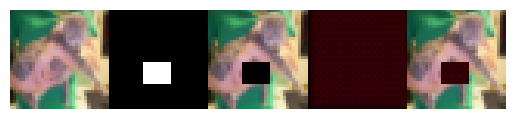

epoch: 0, g_loss: 3.0975, val_loss: 0.2207, d_loss: 8.6330, fake_err: 2.5645, real_err: 14.7014, time: 62.65


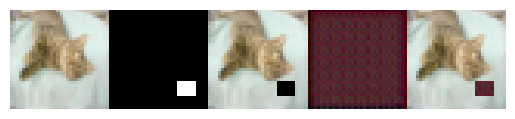

epoch: 1, g_loss: 0.6661, val_loss: 0.1324, d_loss: 7.6069, fake_err: 1.5755, real_err: 13.6383, time: 59.37


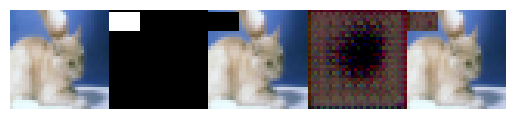

epoch: 2, g_loss: 0.5004, val_loss: 0.1005, d_loss: 7.2185, fake_err: 1.1598, real_err: 13.2772, time: 60.29


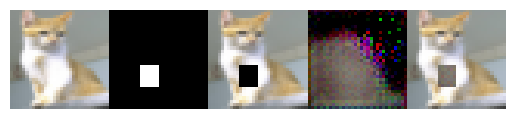

epoch: 3, g_loss: 0.4357, val_loss: 0.0997, d_loss: 7.0028, fake_err: 0.9787, real_err: 13.0269, time: 58.58


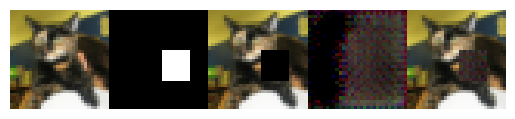

epoch: 4, g_loss: 0.3910, val_loss: 0.0598, d_loss: 6.8241, fake_err: 0.8452, real_err: 12.8031, time: 59.36


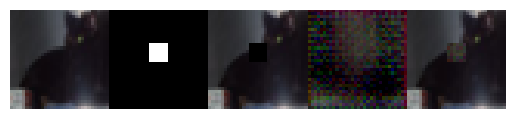

epoch: 5, g_loss: 0.3605, val_loss: 0.0324, d_loss: 6.6887, fake_err: 0.7372, real_err: 12.6403, time: 57.71


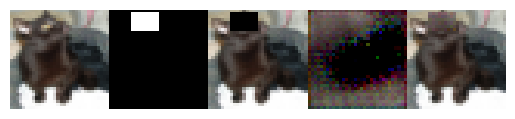

epoch: 6, g_loss: 0.3508, val_loss: 0.0383, d_loss: 6.5870, fake_err: 0.6697, real_err: 12.5043, time: 60.10


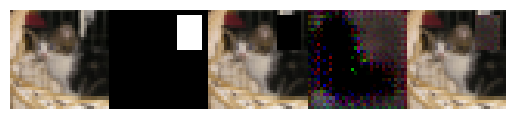

epoch: 7, g_loss: 0.3325, val_loss: 0.0264, d_loss: 6.5050, fake_err: 0.6024, real_err: 12.4077, time: 57.43


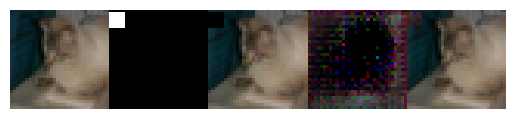

epoch: 8, g_loss: 0.3176, val_loss: 0.0255, d_loss: 6.4051, fake_err: 0.5435, real_err: 12.2668, time: 60.54


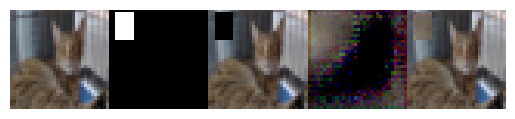

epoch: 9, g_loss: 0.3012, val_loss: 0.0273, d_loss: 6.3385, fake_err: 0.5047, real_err: 12.1723, time: 57.40


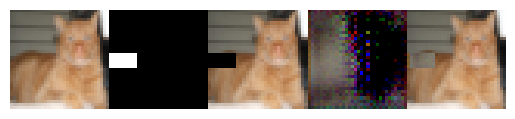

epoch: 10, g_loss: 0.3051, val_loss: 0.0257, d_loss: 6.2738, fake_err: 0.4800, real_err: 12.0677, time: 60.03


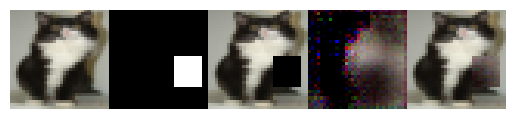

epoch: 11, g_loss: 0.2913, val_loss: 0.0224, d_loss: 6.2186, fake_err: 0.4504, real_err: 11.9869, time: 56.90


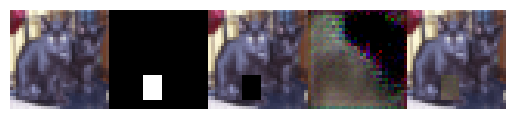

epoch: 12, g_loss: 0.2867, val_loss: 0.0229, d_loss: 6.1390, fake_err: 0.4068, real_err: 11.8712, time: 60.18


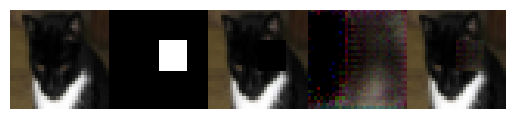

epoch: 13, g_loss: 0.2808, val_loss: 0.0270, d_loss: 6.0930, fake_err: 0.3922, real_err: 11.7938, time: 57.36


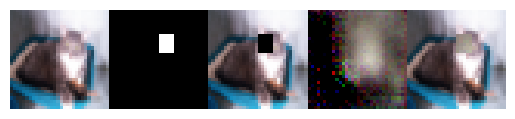

epoch: 14, g_loss: 0.2757, val_loss: 0.0224, d_loss: 6.0516, fake_err: 0.3793, real_err: 11.7239, time: 59.76


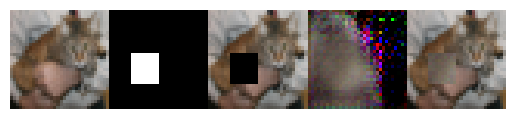

epoch: 15, g_loss: 0.2670, val_loss: 0.0226, d_loss: 5.9916, fake_err: 0.3554, real_err: 11.6277, time: 57.43


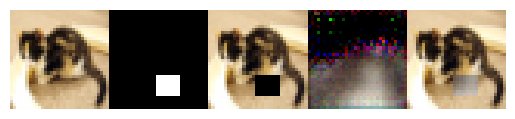

epoch: 16, g_loss: 0.2642, val_loss: 0.0242, d_loss: 5.9483, fake_err: 0.3365, real_err: 11.5601, time: 59.62


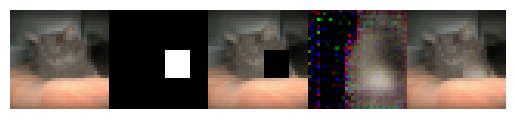

epoch: 17, g_loss: 0.2645, val_loss: 0.0214, d_loss: 5.9025, fake_err: 0.3243, real_err: 11.4807, time: 58.64


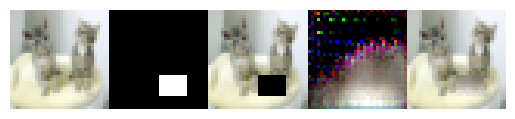

epoch: 18, g_loss: 0.2590, val_loss: 0.0212, d_loss: 5.8628, fake_err: 0.3178, real_err: 11.4077, time: 59.24


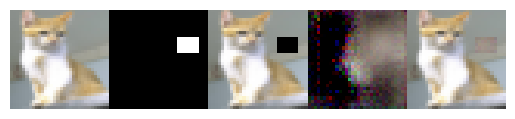

epoch: 19, g_loss: 0.2535, val_loss: 0.0234, d_loss: 5.8146, fake_err: 0.3016, real_err: 11.3275, time: 57.49


In [29]:
train_params = {}
train_params['w'] = 0.0005
train_params['learning_rate_g'] = 0.0001
train_params['learning_rate_d'] = 0.00001
train_params['batch_size'] = 800
train_params['val_batch_size'] = 1024
train_params['T_c'] = 0
train_params['T_d'] = 0
train_params['epochs'] = 20 + train_params['T_c'] + train_params['T_d']

def gen_masks(N, ch=3):
    masks, bounds = create_hole_masks(N, 32, 32, (5, 12), (5, 12), same_size=False)
    return masks.repeat_interleave(ch, dim=1).cuda(), bounds

optimizer_g = torch.optim.Adam(generator.parameters(), lr=train_params['learning_rate_g'])
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=train_params['learning_rate_d'])

torch.cuda.empty_cache()
train_gan(generator, discriminator, transformed_train_dataset, transformed_val_dataset, optimizer_g, optimizer_d, train_params, gen_masks)

# Eval


In [35]:
loss = 0
pixels = 0

In [36]:
model = generator
model.eval()
N = 512
test_loader = iter(DataLoader(transformed_test_dataset, N, shuffle=True, pin_memory=False))

for batch, _ in test_loader:
    masks, _ = gen_masks(batch.shape[0])
    batch_masked = batch.clone().cuda() * (1 - masks)
    batch_masked = torch.cat((batch_masked, masks[:, :1]), dim=1)
    pred = model(batch_masked).clamp(0, 1).detach()

    loss += (((batch.cuda() - pred) * masks)**2).sum().detach().cpu()
    pixels += masks.sum().detach().cpu()

#     inpainted = batch.clone()
#     masks_byte = masks.byte()
#     inpainted[masks_byte] = pred[masks_byte].view(-1)
#     border = torch.zeros((3, 32, 2)) + 0.2196

print(loss / pixels)

# for i in range(batch.shape[0]):
#     imgs = [
#         batch[i].cpu(),
#         border,
#         batch_masked[:, :-1][i].cpu(),
# #         pred[i].cpu(),
#         border,
#         inpainted[i].cpu()
#     ]
#     tmp = torch.cat(imgs, dim=2)
#     imshow(tmp)
#     plt.axis('off')
#     plt.show()

tensor(0.0213)
